In [1]:
import numpy as np
import sys
sys.path.append('../../')
sys.path.append('../../pyfos/')
from pyfos.models.feedforward import build_feedforward
from pyfos.generic.optimizer import gd_optimizer
from pyfos.generic.regularizers import gaus_prior
from functools import partial 
from pyfos.tc.simple import  simple_tc
from pyfos.tc.cv import  cv_tc
from pyfos.hyperoptimizers.drmad_optimize import drmad_optimize
import theano
%matplotlib inline
import matplotlib.pylab as plt
import random
from pyfos.models.var_feedforward import build_var_feedforward

In [7]:
matrix = np.load('../../../data/matrix.npy')
X, Y = np.load('../../../data/linearx.npy'), np.load('../../../data/lineary.npy')
X_train = X[:100]
Y_train = Y[:100]
X_test = X[100:]
Y_test = Y[100:]
lr = theano.shared(10**(-3))
alphas = theano.shared(np.array([1.0, 1.0]))

optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_var_feedforward, init_sigmas=[1.0, 1.0], structure = [2,1], nonlinearity=lambda x:x, alphas=alphas, bias=False, param_pool_size=100)



In [4]:
alpha_ranges = []
for i in xrange(7):
    for j in xrange(7):
        a1 = np.sqrt(10**(i))
        a2 = np.sqrt(10**(j))
        alpha_ranges.append(np.array([a1,a2]))
    
print alpha_ranges    
lr_ranges =   [10**(-2), 0.5*10**(-2), 10**(-3), 0.5*10**(-3)]

[array([ 1.,  1.]), array([ 1.        ,  3.16227766]), array([  1.,  10.]), array([  1.       ,  31.6227766]), array([   1.,  100.]), array([   1.        ,  316.22776602]), array([    1.,  1000.]), array([ 3.16227766,  1.        ]), array([ 3.16227766,  3.16227766]), array([  3.16227766,  10.        ]), array([  3.16227766,  31.6227766 ]), array([   3.16227766,  100.        ]), array([   3.16227766,  316.22776602]), array([    3.16227766,  1000.        ]), array([ 10.,   1.]), array([ 10.        ,   3.16227766]), array([ 10.,  10.]), array([ 10.       ,  31.6227766]), array([  10.,  100.]), array([  10.        ,  316.22776602]), array([   10.,  1000.]), array([ 31.6227766,   1.       ]), array([ 31.6227766 ,   3.16227766]), array([ 31.6227766,  10.       ]), array([ 31.6227766,  31.6227766]), array([  31.6227766,  100.       ]), array([  31.6227766 ,  316.22776602]), array([   31.6227766,  1000.       ]), array([ 100.,    1.]), array([ 100.        ,    3.16227766]), array([ 100.,   10.

In [8]:

drmad_optimize(partial(simple_tc, batch_size=100), model_build, optimizer, 50, 75, 10,  X_train, Y_train, 
    [alphas], lr,  lr=1.0,  lr_for_learning_rate=10**(-8), verbose=10)

trial 0
iteration 0, internal loss=-443.039999136
validation score:  -202.215804402
reverse-iteration 0, gradients:[[ 1.72011252  0.45150307]]
lr gradient: 7877.1317074
new hyperparam values: [array([ 1.50606065,  1.49689685])]
new learning rate: 0.0020074470903
trial 1
iteration 0, internal loss=-621.368794001
validation score:  -168.999376826
reverse-iteration 0, gradients:[[-0.22365882 -0.0531231 ]]
lr gradient: 1101.47505441
new hyperparam values: [array([ 1.22839052,  1.548127  ])]
new learning rate: 0.00249171324036
trial 2
iteration 0, internal loss=-472.315449778
validation score:  -167.980390243
reverse-iteration 0, gradients:[[ 0.19900091 -0.06124982]]
lr gradient: 513.508023494
new hyperparam values: [array([ 1.39822136,  1.45951632])]
new learning rate: 0.00258725266931
trial 3
iteration 0, internal loss=-422.620084152
validation score:  -162.457041845
reverse-iteration 0, gradients:[[-0.011793   -0.00204225]]
lr gradient: 424.219642965
new hyperparam values: [array([ 1.272

<structures.HyperparameterOptimization instance at 0x7f361bd14878>

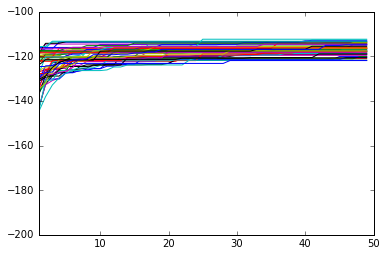

In [21]:
for b in bests:
    history = []
    for i in xrange(0, len(b.history)):
        
        best_value = max([h[1] for h in b.history[:i+1]])
        
        
        history.append(best_value)
    plt.plot(history)
plt.ylim((-200, -100))
plt.xlim((1,50))
import cPickle
with open('results_var_mad.pckl','wb') as out:
    cPickle.dump(bests, out)

(2, 50)

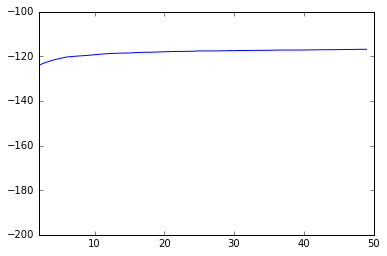

In [18]:
import theano.tensor as T
X = T.matrix()
result = []
for b in bests:
    print b.best_values
    alphas.set_value(b.best_values[0])
    lr.set_value(b.best_values[1])
    training_procedure = cv_tc( build_feedforward, optimizer, X_train, Y_train, validation_part=0.0, batch_size=100 )
    
    for i in xrange(10):
        training_procedure.do_train()
    
    for m in training_procedure.models:
        predict = m.predict_var(X)
        predict = theano.function([X], predict)
    
        result.append(np.mean((predict(X_test)-Y_test)**2))
        print result[-1]
    """
    bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
     [alpha_ranges, lr_ranges], verbose=100))
    X = T.matrix()    
    model = model_build(dataset_size=100)
    
    
    """
print np.mean(result)
print np.std(result)

[array([  30.00214416,  999.94999882]), array(0.0033518796166409903)]
4.35820653185
[array([ 999.94999882,    1.1647706 ]), array(0.010000027997209353)]
4.48466193665
[array([ 316.06961476,  316.06961513]), array(0.005094404508539035)]
4.40680896789
[array([   1.15177802,  999.94999883]), array(0.005087284843156676)]
4.40665254156
[array([ 30.0024417 ,  30.00283923]), array(0.010000035397256213)]
4.4846620314
[array([ 2.00443554,  2.13604096]), array(0.0033142158422259107)]
4.35682504625
[array([ 99.49880455,  81.53195977]), array(0.0033237007642474463)]
4.35717485112
[array([ 99.49880478,  30.00251847]), array(0.0033539568035129796)]
4.3582821384
[array([  30.00240418,  999.94999883]), array(0.0050944137447119005)]
4.40680917066
[array([ 99.4988046 ,   1.04185849]), array(0.0033009063801419736)]
4.35633200384
[array([ 30.00239708,   1.13347616]), array(0.005092368063805293)]
4.40676424967
[array([ 99.4988047 ,  97.35454862]), array(0.00332509880288015)]
4.35722630185
[array([   1.0827

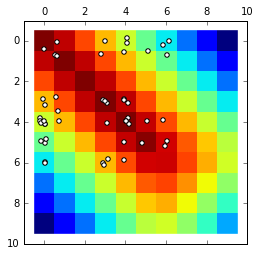

In [22]:
plt.matshow(matrix)
for i in bests:
    i = i.best_values[0]**2
    i = np.log10(i)
    
    plt.scatter(i[0]+np.random.randn(1)*0.1,i[1]+np.random.randn(1)*0.1, c='w', alpha=1.0)

TypeError: ('Bad input argument to theano function with name "../../pyfos/hyperoptimizers/greed_optimize.py:53"  at index 2(0-based)', 'Wrong number of dimensions: expected 2, got 1 with shape (10,).')

UnboundLocalError: local variable 'X2' referenced before assignment

[([array([  31.6227766 ,  316.22776602]), 0.001], array(-127.64285224474986)),
 ([array([ 10.        ,   3.16227766]), 0.01], array(-162.5087255392545)),
 ([array([ 31.6227766 ,   3.16227766]), 0.01], array(-2.7627426873481633e+42)),
 ([array([  10.,  100.]), 0.005], array(-124.3719052719263)),
 ([array([  3.16227766,  31.6227766 ]), 0.01], array(-1.2198974168241432e+41)),
 ([array([ 316.22776602,    1.        ]), 0.001], array(-122.78697142872564)),
 ([array([ 1.,  1.]), 0.01], array(-2.048288202990528e+45)),
 ([array([ 316.22776602,   10.        ]), 0.02], array(nan)),
 ([array([   1.,  100.]), 0.005], array(-127.03124347465777)),
 ([array([  3.16227766,  31.6227766 ]), 0.01], array(-3.879875247817619e+79))]

In [11]:
for i in bests:
    print np.array(i.best_values[0])**2

[  1.00000000e+05   1.00000000e+00]
[ 100.  100.]
[ 100.  100.]
[   1.  100.]
[  1.  10.]


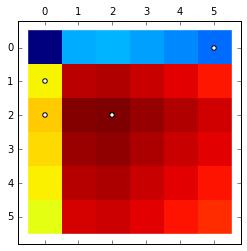

In [12]:
plt.matshow(matrix)
for i in bests:
    i = i.best_values[0]**2
    i = np.log10(i)
    
    plt.scatter(i[0],i[1], c='w')